In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.linalg as la
import scipy.optimize as opt
from scipy.optimize import curve_fit
import pandas as pd
import xlrd
import typing


In [2]:
def correlation(t, A, B, C, D, E):
    y = A*(np.exp(-2*B*t)) + C*(np.exp(-2*D*t)) +E
    return y


In [3]:
def relaxationrate(filename, filetype, Angle):
    
    if filetype == 'excel':
        data = pd.read_excel(filename)
    if filetype == 'csv':
        data = pd.read_csv(filename, encoding= 'unicode_escape')
    
    xlabel = data[data.columns[0]][0]
    ylabel = data[data.columns[1]][0]
    
    Time = data[data.columns[0]][1:201]
    Correlation = data[data.columns[1]][1:201]
    
    x=[]
    y=[]
    
    x = np.array(list(map(float, Time)))
    y = np.array(list(map(float, Correlation)))
    
    parameters, covariance = curve_fit(correlation, x, y, p0 = [0.1,0.1, 0.1, 0.1, 0], bounds = (0, 10) )
    
    best_A = parameters[0]
    best_B = parameters[1]
    best_C = parameters[2]
    best_D = parameters[3]
    best_E = parameters[4]
    #print("A:", best_A)
    print("Relaxation Rate B for",Angle,"deg", best_B, "1/microsec")
    print("Relaxation Rate C for",Angle,"deg", best_C, "1/microsec")
    
    print("E", best_E)
    
    if Angle == 60:
        Color = 'r'
        Figure = 3
    if Angle == 90:
        Color = 'b'
        Figure = 4
    if Angle == 120:
        Color = 'g'
        Figure = 5
    
    fit_y = correlation(x, best_A, best_B, best_C, best_D, best_E)
    plt.figure(Figure)
    plt.plot(x, y, 'o',markersize = 2, color = 'k')
    plt.plot(x, fit_y, '-', label = Angle, color = Color)
    plt.xscale('log')
    plt.xlabel(xlabel)
    plt.ylim([-0.03,0.25])
    plt.ylabel(ylabel)
    plt.title(filename)
    plt.legend()
    #plt.savefig(filename,format='png') #saves over original file right now and kills it making it a png, don't uncomment for now
    
    return [best_B, best_C]


In [4]:
def scatteringvec(RefractiveIndex, Angle): 
    
    RI = RefractiveIndex #Refractive Index of the sample
    wavelength = 637 # Units - nm, comes from the wavelength of the laser used in the DLS
    radian = (Angle*np.pi)/180
    
    q = ( 4*np.pi*(RI)*(np.sin(radian/2)) )/(wavelength) #Units 1/nm
    
    print("Scattering Vector 'q' for",Angle, "deg:", q, "1/nm")
    
    return q


In [5]:
def diffusioncoef(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, RefractiveIndex):
    
    q2 = np.zeros(3)
    q2[0] = scatteringvec(RefractiveIndex, 60)**2 #Units 1/nm
    q2[1] = scatteringvec(RefractiveIndex, 90)**2 #Units 1/nm
    q2[2] = scatteringvec(RefractiveIndex, 120)**2 #Units 1/nm
    
    B = np.zeros(3)
    C = np.zeros(3)
    B[0], C[0] = relaxationrate(sixtydeg_filename, filetype, 60) #Units - 1/microsec
    B[1], C[1] = relaxationrate(nintydeg_filename, filetype, 90) #Units - 1/microsec
    B[2], C[2] = relaxationrate(onetwentydeg_filename, filetype, 120) #Units - 1/microsec
    
    m, b = np.polyfit(q2, B, 1)
    n, c = np.polyfit(q2, C, 1)
    
    plt.figure(1)
    plt.scatter(q2, B)
    plt.plot(q2, m*(q2)+b)
    plt.xlabel("Square Scattering Vector 'q^2' ")
    plt.ylabel("Relaxation Rate")
    plt.title("Diffusion Coefficient B")
    
    plt.figure(2)
    plt.scatter(q2, C)
    plt.plot(q2, n*(q2)+c)
    plt.xlabel("Square Scattering Vector 'q^2' ")
    plt.ylabel("Relaxation Rate")
    plt.title("Diffusion Coefficient C")
    
    D_B = m
    D_C = n
    
    print(" ")
    print("Diffusion Coefficient 'D B':",D_B, "nm^2 / microsec")
    print("Diffusion Coefficient 'D C':",D_C, "nm^2 / microsec")
    print(" ")
    
    return [D_B, D_C]


In [6]:
def hydrorad(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, RefractiveIndex, Viscosity):
    
    kB = 1.380649*(1e-16) #Units - g*cm^2 / K*s^2
    T = 298.15 #Units - Kelvin, room temperature which should be the temperature of the sample
    D_B, D_C= diffusioncoef(sixtydeg_filename, nintydeg_filename, onetwentydeg_filename, filetype, RefractiveIndex)
    D_B = D_B*(1e-8) #Units - converting nm^2 / microsec to cm^2 / s
    D_C = D_C*(1e-8) #Units - converting nm^2 / microsec to cm^2 / s
    
    Rh_B = (kB*T)/(6*np.pi*D_B*Viscosity)*(1e7) #Units - converting cm to nm (depends a lot on units of viscosity)
    Rh_C = (kB*T)/(6*np.pi*D_C*Viscosity)*(1e7) #Units - converting cm to nm (depends a lot on units of viscosity)
    
    print("Hydrodynamic Radius 'Rh B':", Rh_B, "nm")
    print("Hydrodynamic Radius 'Rh C':", Rh_C, "nm")
    
    
    return [Rh_B, Rh_C]


Scattering Vector 'q' for 60 deg: 0.014470067261589406 1/nm
Scattering Vector 'q' for 90 deg: 0.020463765369790658 1/nm
Scattering Vector 'q' for 120 deg: 0.025062891686011907 1/nm
Relaxation Rate B for 60 deg 0.06494750693689724 1/microsec
Relaxation Rate C for 60 deg 0.02727604292399062 1/microsec
E 0.0015252378607516456
Relaxation Rate B for 90 deg 9.074811894410597e-05 1/microsec
Relaxation Rate C for 90 deg 0.14195041268892908 1/microsec
E 0.00831965866107134
Relaxation Rate B for 120 deg 0.11868418711047339 1/microsec
Relaxation Rate C for 120 deg 0.018451404338310426 1/microsec
E 0.011381547853055115
 
Diffusion Coefficient 'D B': 128.32159142387243 nm^2 / microsec
Diffusion Coefficient 'D C': -21.072974054169677 nm^2 / microsec
 
Hydrodynamic Radius 'Rh B': 3.2415888723883164 nm
Hydrodynamic Radius 'Rh C': -19.739304085769437 nm


[3.2415888723883164, -19.739304085769437]

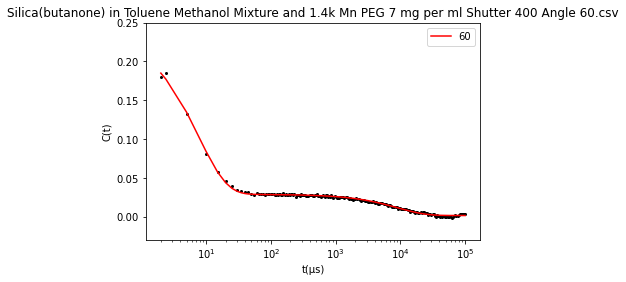

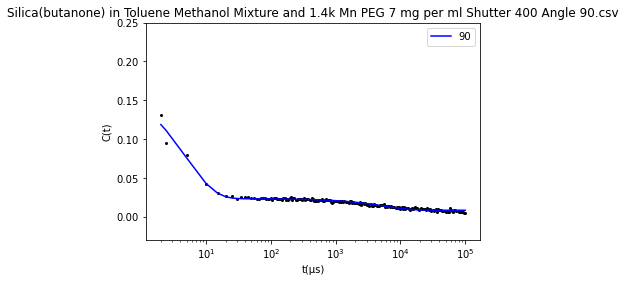

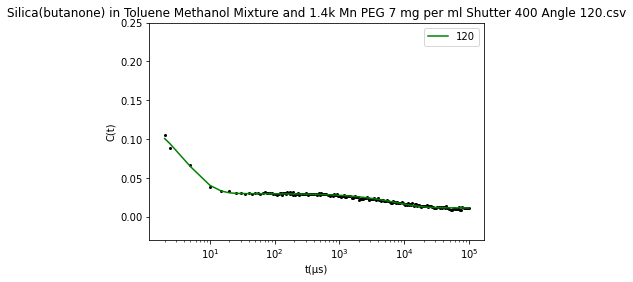

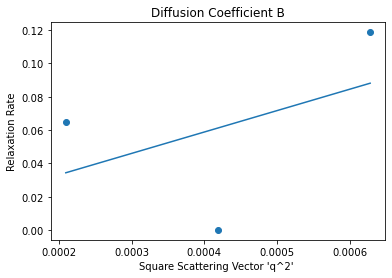

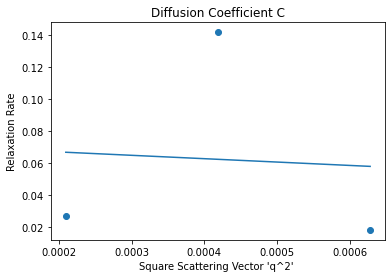

In [7]:
hydrorad(
    
    sixtydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 7 mg per ml Shutter 400 Angle 60.csv' ,
    
    nintydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 7 mg per ml Shutter 400 Angle 90.csv' ,
    
    onetwentydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 7 mg per ml Shutter 400 Angle 120.csv' ,
         
    filetype = 'csv' ,
    #either 'excel' or 'csv'
         
    RefractiveIndex = 1.467 ,
    
    Viscosity = 0.00525
    #Viscosity in units g /cm*s (for all intents and purposes 100 mPa*s = 1 g /cm*s)
         
        )


Scattering Vector 'q' for 60 deg: 0.014470067261589406 1/nm
Scattering Vector 'q' for 90 deg: 0.020463765369790658 1/nm
Scattering Vector 'q' for 120 deg: 0.025062891686011907 1/nm
Relaxation Rate B for 60 deg 0.05262646765030058 1/microsec
Relaxation Rate C for 60 deg 0.056230368623445 1/microsec
E 0.020839184800582364
Relaxation Rate B for 90 deg 0.10471250778412465 1/microsec
Relaxation Rate C for 90 deg 0.036795898110918664 1/microsec
E 0.014511897214025186
Relaxation Rate B for 120 deg 7.269880968330299e-05 1/microsec
Relaxation Rate C for 120 deg 0.11564594752192522 1/microsec
E 0.00840530552165767
 
Diffusion Coefficient 'D B': -125.49683440002386 nm^2 / microsec
Diffusion Coefficient 'D C': 141.88263240297323 nm^2 / microsec
 
Hydrodynamic Radius 'Rh B': -3.314552473259085 nm
Hydrodynamic Radius 'Rh C': 2.9317601161033155 nm


[-3.314552473259085, 2.9317601161033155]

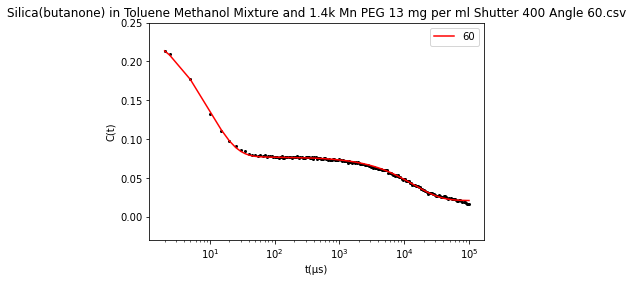

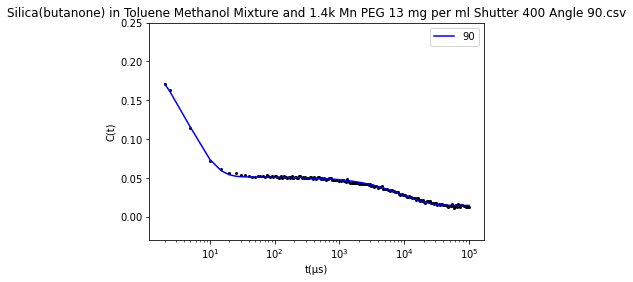

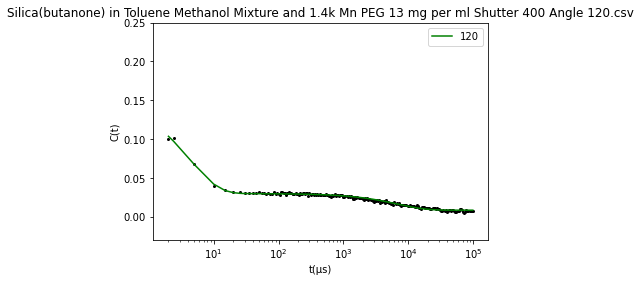

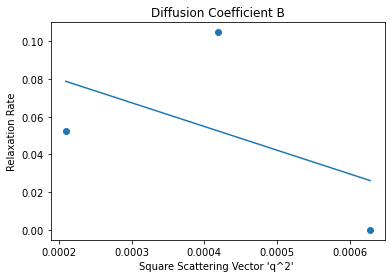

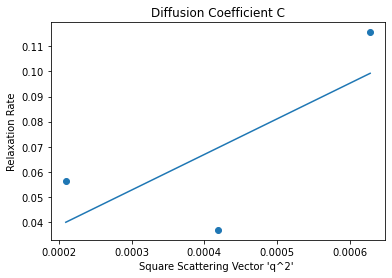

In [8]:
hydrorad(
    
    sixtydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 13 mg per ml Shutter 400 Angle 60.csv' ,
    
    nintydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 13 mg per ml Shutter 400 Angle 90.csv' ,
    
    onetwentydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 13 mg per ml Shutter 400 Angle 120.csv' ,
         
    filetype = 'csv' ,
    #either 'excel' or 'csv'
         
    RefractiveIndex = 1.467 ,
    
    Viscosity = 0.00525
    #Viscosity in units g /cm*s (for all intents and purposes 100 mPa*s = 1 g /cm*s)
         
        )

Scattering Vector 'q' for 60 deg: 0.014470067261589406 1/nm
Scattering Vector 'q' for 90 deg: 0.020463765369790658 1/nm
Scattering Vector 'q' for 120 deg: 0.025062891686011907 1/nm
Relaxation Rate B for 60 deg 3.678997951441415e-05 1/microsec
Relaxation Rate C for 60 deg 0.21445576555648566 1/microsec
E 0.015410224602498754
Relaxation Rate B for 90 deg 0.10757288282386801 1/microsec
Relaxation Rate C for 90 deg 0.0205470498695702 1/microsec
E 0.010057185419465634
Relaxation Rate B for 120 deg 9.556269002711076e-05 1/microsec
Relaxation Rate C for 120 deg 0.11166872363637621 1/microsec
E 0.003928942712352432
 
Diffusion Coefficient 'D B': 0.14034748184914814 nm^2 / microsec
Diffusion Coefficient 'D C': -245.4523940506947 nm^2 / microsec
 
Hydrodynamic Radius 'Rh B': 2963.828330699114 nm
Hydrodynamic Radius 'Rh C': -1.6946905099685972 nm


[2963.828330699114, -1.6946905099685972]

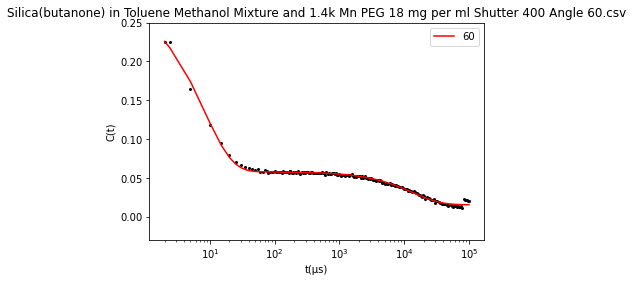

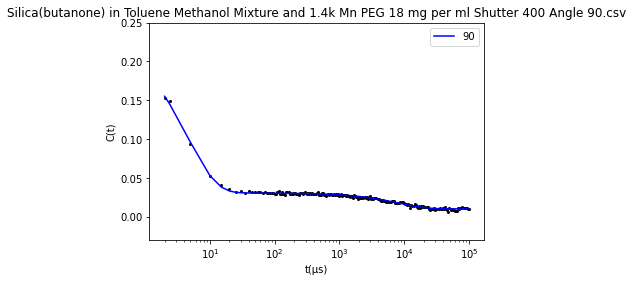

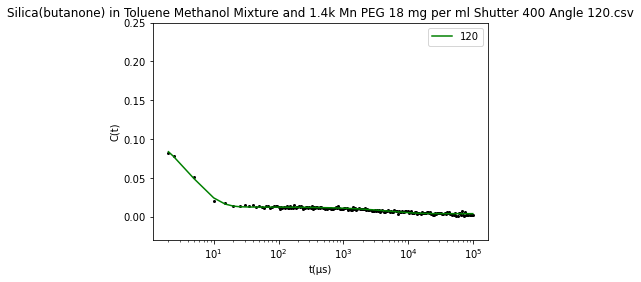

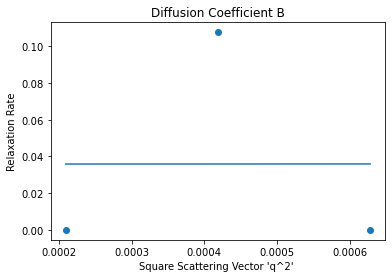

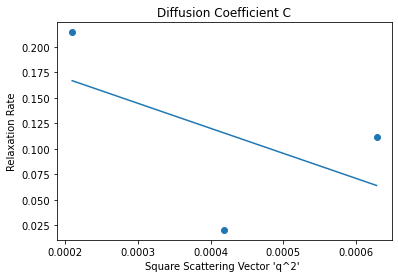

In [9]:
hydrorad(
    
    sixtydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 18 mg per ml Shutter 400 Angle 60.csv' ,
    
    nintydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 18 mg per ml Shutter 400 Angle 90.csv' ,
    
    onetwentydeg_filename = 'Silica(butanone) in Toluene Methanol Mixture and 1.4k Mn PEG 18 mg per ml Shutter 400 Angle 120.csv' ,
         
    filetype = 'csv' ,
    #either 'excel' or 'csv'
         
    RefractiveIndex = 1.467 ,
    
    Viscosity = 0.00525
    #Viscosity in units g /cm*s (for all intents and purposes 100 mPa*s = 1 g /cm*s)
         
        )